In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
ROOT_PATH = Path().resolve().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
DIR_PATH = Path().resolve()
from frequency_response import FrequencyResponse
from research.peq_optimizer.neural_peq import NeuralPEQ

## Create Data

In [3]:
# Read equalization curves from results as data
# TODO: Create data generator for unlimited data
data_path =  DIR_PATH.joinpath('data.npy')
if data_path.is_file():
    # Saved previously to numpy file
    data = np.load(data_path)
else:
    # Not saved, read frequency response CSVs
    data = []
    for fp in ROOT_PATH.joinpath('results').glob('**/*.csv'):
        fr = FrequencyResponse.read_from_csv(fp)
        fr.interpolate()
        data.append(fr.equalization)
    data = np.vstack(data)
    np.save(data_path, data)

# Split data into training and testing
n_train = int(len(data) * 0.8)
n_test = len(data) - n_train
train = data[:n_train]
test = data[n_train:]

In [ ]:
peq = NeuralPEQ(
    n_filters=10,
    hidden_size=1024,
    learning_rate=2e-4,
    learning_rate_decay=0.01,
    log_f=True,
    q_normalization=1.0,
    gain_normalization=1.0,
    warmup_epochs=3)
peq.train(train)

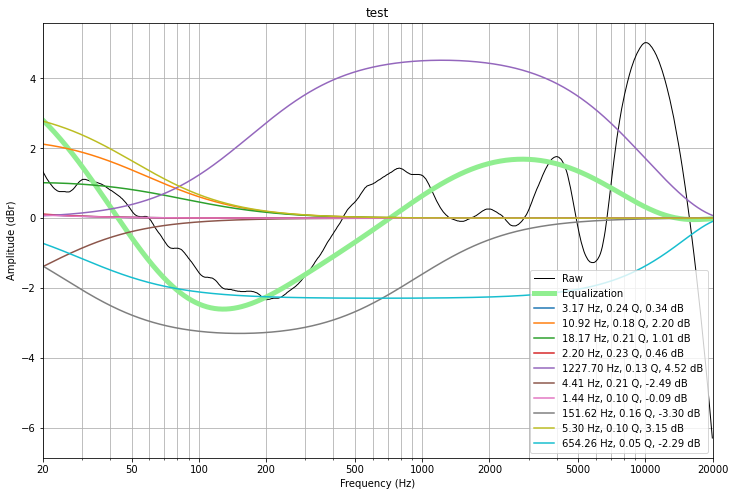

In [164]:
for i in range(3,4):
    filters = peq.infer(test[i:i+1])
    fr = FrequencyResponse(name='test', raw=test[i], equalization=np.squeeze(peq.fr(filters)), target=test[i])
    fr.error = fr.raw - fr.target
    fig, ax = fr.plot_graph(show=False, raw=True, target=False, error=False)
    for i, filt in enumerate(filters[0]):
        ax.plot(fr.frequency, np.squeeze(peq.fr(np.expand_dims(np.expand_dims(filt, axis=0), axis=0))), label=f'{filt[0]:.2f} Hz, {filt[1]:.2f} Q, {filt[2]:.2f} dB')
    ax.legend()
    plt.show()

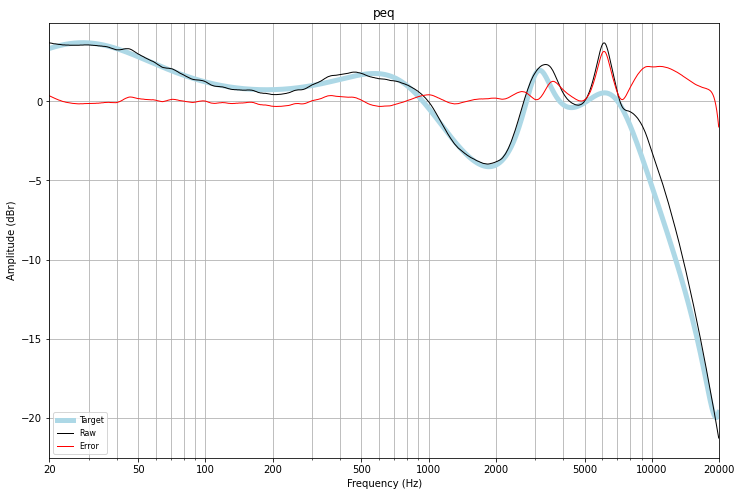

In [15]:
p = np.array([
    [ 2.8177048e+01, 4.6592656e-01, 3.6886775e+00],
    [ 7.5532819e+02, 6.3449883e-01, 4.0352540e+00],
    [ 2.1447576e+03, 4.8449698e-01, -7.1967192e+00],
    [ 3.0843210e+03, 2.0635529e+00, 6.9372535e+00],
    [ 6.6201890e+03, 8.5014981e-01, 6.9353619e+00],
    [ 1.9410781e+04, 2.7364632e-01, -2.0113779e+01]], dtype='float32')
p = np.expand_dims(p, axis=0)
raw = peq.fr(p)
fr = FrequencyResponse(name='peq', raw=test[0], target=np.squeeze(raw))
fr.error = fr.raw - fr.target
fr.plot_graph()
plt.show()

In [143]:
d = ((p[:, :, 1] - 1.41) ** 2).T
d = np.hstack([np.ones((p.shape[1], p.shape[2]-1)), d])

In [144]:
d

array([[1.        , 1.        , 0.89127463],
       [1.        , 1.        , 0.60140198],
       [1.        , 1.        , 0.85655582],
       [1.        , 1.        , 0.42713138],
       [1.        , 1.        , 0.31343219],
       [1.        , 1.        , 1.29129958]])

In [145]:
p

array([[[ 2.8177048e+01,  4.6592656e-01,  3.6886775e+00],
        [ 7.5532819e+02,  6.3449883e-01,  4.0352540e+00],
        [ 2.1447576e+03,  4.8449698e-01, -7.1967192e+00],
        [ 3.0843210e+03,  2.0635529e+00,  6.9372535e+00],
        [ 6.6201890e+03,  8.5014981e-01,  6.9353619e+00],
        [ 1.9410781e+04,  2.7364632e-01, -2.0113779e+01]]], dtype=float32)

In [146]:
p*d

array([[[ 2.81770477e+01,  4.65926558e-01,  3.28762472e+00],
        [ 7.55328186e+02,  6.34498835e-01,  2.42680977e+00],
        [ 2.14475757e+03,  4.84496981e-01, -6.16439169e+00],
        [ 3.08432104e+03,  2.06355286e+00,  2.96311868e+00],
        [ 6.62018896e+03,  8.50149810e-01,  2.17376564e+00],
        [ 1.94107812e+04,  2.73646325e-01, -2.59729145e+01]]])